# Updating the SARIMA model
- added more years of data
- decided against using the boxcox transformation for normalizing data in favor of the `MinMaxScaler` which is more interpretable
- changed the forecast horizon to 7 days
- customized the `auto_arima` to use AIC for model selection

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from seaborn import set_style
set_style=("whitegrid")

In [8]:
L=[]
for i in range(2018,2024): #adjust here when we get more years of data
    L.append(pd.read_csv('data/pub_data_'+str(i)+'.csv',header=None, delimiter="|"))

df=pd.concat(L, ignore_index=True)

df=df.rename(columns={0:'PcrKey',1:'eTimes_03',2:'eDispatch_01'})
df['DateTime']=pd.to_datetime(df['eTimes_03'],exact=False, errors='coerce')
format='%Y-%m-%d %H:%M:%S'
#after 2019, switches datetime format, so need to fix the NaT errors
df.loc[df.DateTime.isna(),'DateTime']=pd.to_datetime(df.loc[df.DateTime.isna(),'eTimes_03'], format='%d%b%Y:%H:%M:%S',exact=False, errors='coerce')
#create Date column (only date without time)
df['Date']=df.DateTime.apply(lambda x : x.date())
df['Year']=df.DateTime.apply(lambda x : x.year)

#create data: stores the number of calls each day
# want to normalize each year and then append all together
L=[]
scaler=MinMaxScaler()
for i in range(2018,2024):
    yeardata=df.loc[df.Year==i,'Date'].value_counts().sort_index().reset_index().rename(columns={'index':'Value','Date':'date'})
    yeardata['count']=scaler.fit_transform(yeardata['count'].values.reshape(-1, 1))
    L.append(yeardata)

data=pd.concat(L, ignore_index=True)

data

,date,count
0,2018-01-01,0.208333
1,2018-01-02,0.458333
2,2018-01-03,0.458333
3,2018-01-04,0.375000
4,2018-01-05,0.541667
...,...,...
2186,2023-12-27,0.508197
2187,2023-12-28,0.426230
2188,2023-12-29,0.737705
2189,2023-12-30,0.770492


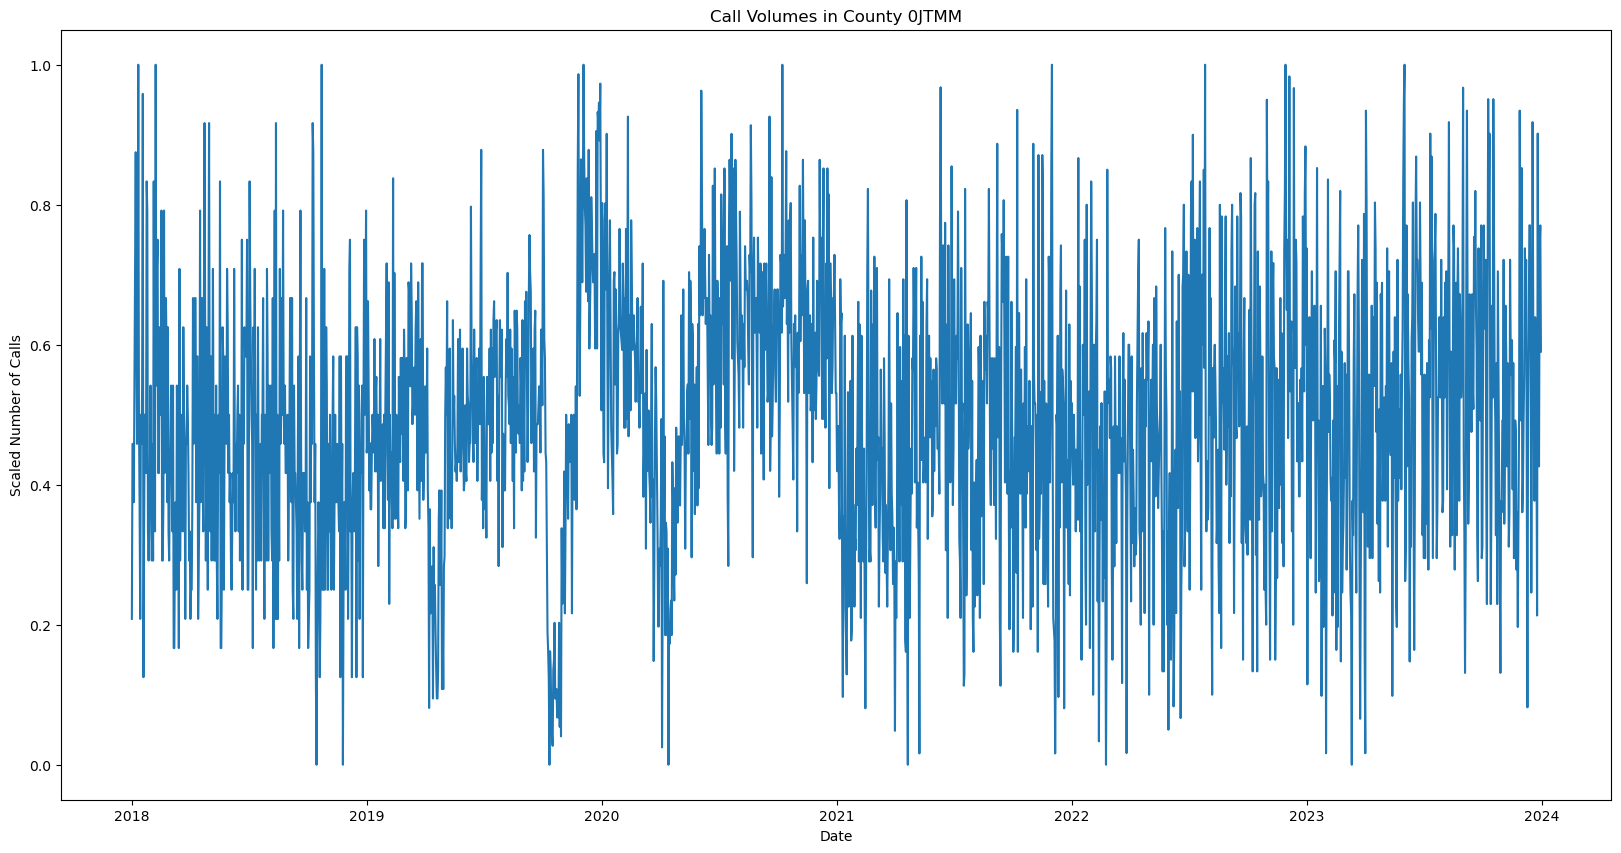

In [9]:
#Plot of the number of calls each day
plt.figure(figsize=(20,10))
plt.plot(data['date'], data['count'])
plt.title('Call Volumes in County 0JTMM')
plt.xlabel('Date')
plt.ylabel('Scaled Number of Calls')
plt.show()

In this graph, we see that the call volumes is more stabilized due to scaling each year individually. This allows us to have a stationary data set necessary for fitting the SARIMA models.

In [10]:
# Train test split: first 90%
train=data.iloc[:-int(len(data)*0.1)]
test=data.iloc[-int(len(data)*0.1):]

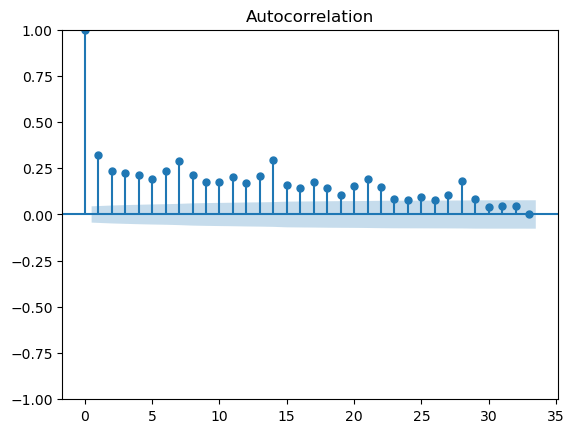

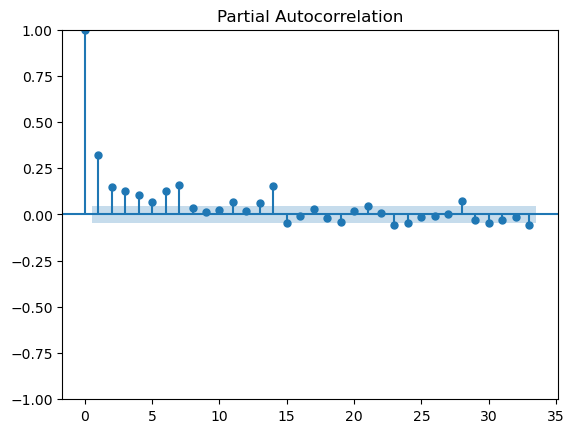

In [11]:
#Modelling
#(partial) autocorrelation plots
# autocorrelation: correlation between x_n and x_{n-i}
# partial ac: correlation between the linear combination of x_{n,n-1,...n-i+1} and x_{n-i}
# useful in finding parameters p and q
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), dpi=80)
plot_acf(train['count'])
plot_pacf(train['count'], method='ywm')
#ax1.tick_params(axis='both', labelsize=12)
#ax2.tick_params(axis='both', labelsize=12)
plt.show()

## Observations about autocorrelation

The ACF and PACF display signigicant lags at multiples of 7, which implies a weekly seasonality. 

## Model selection using the Akaike information Criterion (AIC)

The `auto_arima` function searches through ARIMA models and computes the AIC, which estimates prediction error and allows us to weigh the relative quality of certain models. We will select 3 models with low AIC values and compare them using cross validation.

In [12]:
from pmdarima import auto_arima
auto_arima(train['count'], trace=True, start_p=1,max_d=2, start_q=1, max_p=8, max_q=8, start_P=0, start_Q=1, max_D=2, max_P=8, max_Q=8, m=7, stepwise=False)

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-409.991, Time=0.17 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-420.942, Time=0.25 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=-463.716, Time=0.65 sec
 ARIMA(0,1,0)(0,0,3)[7] intercept   : AIC=-463.574, Time=3.08 sec
 ARIMA(0,1,0)(0,0,4)[7] intercept   : AIC=-479.884, Time=5.49 sec
 ARIMA(0,1,0)(0,0,5)[7] intercept   : AIC=-482.772, Time=5.33 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-425.151, Time=0.23 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=3.50 sec
 ARIMA(0,1,0)(1,0,3)[7] intercept   : AIC=inf, Time=14.07 sec
 ARIMA(0,1,0)(1,0,4)[7] intercept   : AIC=inf, Time=17.46 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-475.679, Time=0.65 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=3.49 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=3.54 sec
 ARIMA(0,1,0)(2,0,3)[7] intercept   : AIC=inf, Time=14.15 sec
 ARIMA(0,1,0)(3,0,0)[7] intercept   : AIC=

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(3, 0, 1, 7),
      suppress_warnings=True)

## Model Comparison
We will compare some models using time series cross validation
- Model 0: baseline naive forecast
- Model 1: baseline average forecast
- Model 2: SARIMA model 011 301 7

Note that in each of the SARIMA models, the sum of the parameters is the same, so none of them are advantaged against one another in terms of overfitting. These models were selected by the `auto_arima` search which looked for models minimizing the AIC criterion.

Cross validation scheme:
- forecast horizon of 7 days
- reserve last 10% of data as testing set, so do not look at it during CV
- 10 fold cross validation
    - Fold 1: Train on [:-70], predict [-70:-70-7]
    - $\vdots$
    - Fold 10: Train on [:-7], predict [-7:]

In [ ]:
import statsmodels.tsa.api as sm

model0_preds = [] #naive
model1_preds = [] #constant (average)
model2_preds = [] #custom sarima 011 3017

for i in range(-10,0):
    y_tt = train['count'].values[:(7*i)]
    y_ho = train['count'].values[(7*i):(7*(i+1))]

    model2=sm.ARIMA(y_tt, order=(0,1,1), seasonal_order=(3,0,1,7)).fit()

    # Naive predictions
    model0_preds.append(y_tt[-1]*np.ones(7))

    # Constant baseline predictions
    model1_preds.append(np.average(y_tt)*np.ones(7))
    
    model2_preds.append(model2.forecast(7))

c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Kar

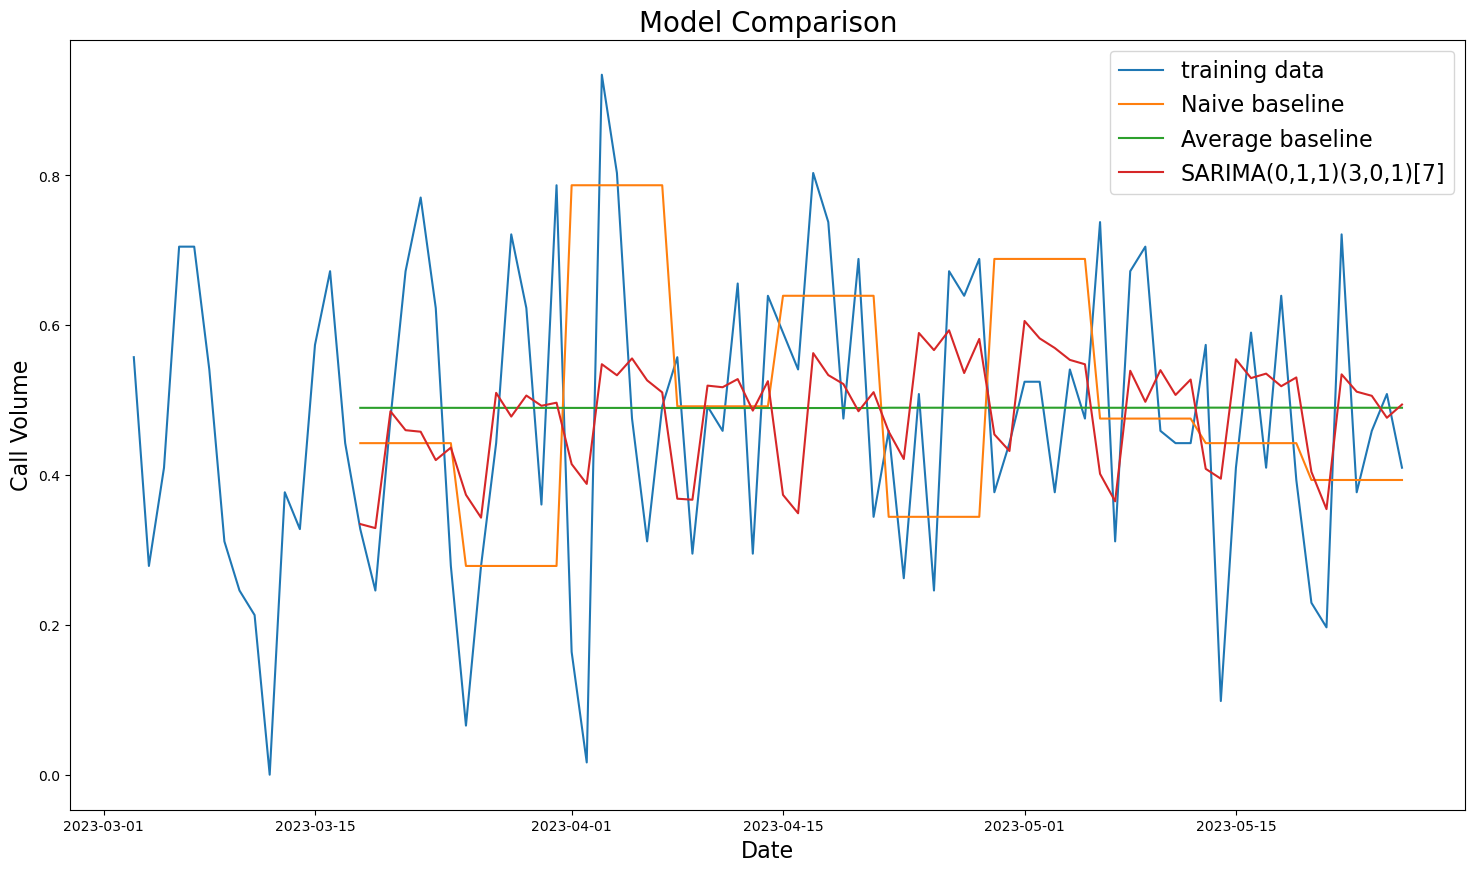

In [22]:
#adjust
plt.figure(figsize=(18,10))
plt.plot(train['date'][-85:], train['count'][-85:], label='training data')
plt.plot(train['date'][-70:], np.concatenate(model0_preds), label = 'Naive baseline')
plt.plot(train['date'][-70:], np.concatenate(model1_preds), label = 'Average baseline')
plt.plot(train['date'][-70:], np.concatenate(model2_preds), label = 'SARIMA(0,1,1)(3,0,1)[7]')

plt.title('Model Comparison', fontsize=20)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Call Volume',fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error as mse

mse0 = mse(train['count'][-70:],np.concatenate(model0_preds))
mse1 = mse(train['count'][-70:],np.concatenate(model1_preds))
mse2 = mse(train['count'][-70:],np.concatenate(model2_preds))

unordered_dict = {'Naive baseline model':mse0, 'Average baseline model':mse1, 'SARIMA model':mse2}
ordered_dict = dict(sorted(unordered_dict.items(), key=lambda item: item[1], reverse=True))
ordered_dict

{'Naive baseline model': np.float64(0.056582331938419016),
 'Average baseline model': np.float64(0.036396180724181965),
 'SARIMA model': np.float64(0.029421562709914008)}

We see that Model 0 (naive forecast) had the largest MSE, followed by Model 1 (average forecast), and the selected SARIMA model performed the best.